In [94]:
%matplotlib inline
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [112]:
# load data
def load_data():
    working_folder = ".."
    data_folder = "data"
    format1_fdir = 'data_format1_20180930_20181007.h5'#data_format1_201808.h5'#923_20180930.h5'#
    format2_fdir = 'data_format2_20180930_20181007.h5'#data_format2_201808.h5'#923_20180930.h5'#

    format1_dir = os.path.join(working_folder, data_folder, format1_fdir)
    format2_dir = os.path.join(working_folder, data_folder, format2_fdir)

    sys.path.append(working_folder)

    f1_data = pd.HDFStore(format1_dir)
    keys = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
    series_avg = pd.DataFrame()
    for key in keys:
        series_avg[key] = (0.25 * (f1_data[key]['close'] + f1_data[key]['open'] + f1_data[key]['high'] + f1_data[key]['low']))
    # TODO add volume
    f1_data.close()
    return series_avg, keys

In [113]:
# define func
def train_test_split_self(data_x, data_y, test_size=0.33):
    size = len(data_x)
    train_size = int(len(data_x) * test_size)
    return data_x[:train_size], data_x[train_size:], data_y[:train_size], data_y[train_size:]

In [114]:
# train model
def train_model(data_x, data_y, is_plot:bool=False, is_print:bool=False):
    
    X_train, X_test, y_train, y_test = train_test_split_self(data_x, data_y, test_size=0.33)#, random_state=42)

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # The mean squared error
    mse = mean_squared_error(y_test, y_pred)
    # Explained variance score: 1 is perfect prediction
    score = r2_score(y_test, y_pred)

    if is_print:
        print("Mean squared error: %.2f" % mse)
        print('Variance score: %.2f' % score)
         # The coefficients
        print('Coefficients: \n', regr.coef_)
        print('Intercept: \n', regr.intercept_)

    # Plot outputs
    if is_plot:
        fig = plt.figure(figsize=(20,10))
        x_axis = np.arange(len(X_test))
        plt.scatter(x_axis,y_test,  color='black')
        plt.plot(x_axis, y_pred, color='blue', linewidth=3)

        plt.xticks(())
        plt.yticks(())

        plt.show()
    
    
    return regr, {'mse':mse, 'score':score}

In [115]:
# load data
series_avg, keys = load_data()
# train model
shift_period = 5
data_length = 60 * 24 * 7
asset = keys[1]


models_mse = dict()
models_score = dict()

# train
for asset in keys:
    mses = []
    scores = []
    models_mse[asset] = mses
    models_score[asset] = scores
    for shift_period in range(1,100):
        # Load the diabetes dataset
        all_asset = keys.copy()
        # all_asset.remove(asset)
        data_x = series_avg[all_asset].values[:-1*shift_period]
        data_y = series_avg[asset].shift(-1 * shift_period)[:-1*shift_period].values
        data_x = data_x[:data_length]
        data_y = data_y[:data_length]

        model, judge_dict = train_model(data_x, data_y, is_plot=False, is_print=False)
        
        
        mses.append(judge_dict['mse']  / model.intercept_)#math.sqrt(judge_dict['mse']) / model.intercept_)
        scores.append(judge_dict['score'])
        
#         print(f"asset: {asset}, shift_period: {shift_period}")
#         print("Mean squared error: %.2f" % judge_dict['mse'])
#         print('Variance score: %.2f' % judge_dict['score'])
#         print('Coefficients: ', model.coef_)
#         print('Intercept: ', model.intercept_)
#         print('---------------------------------------')

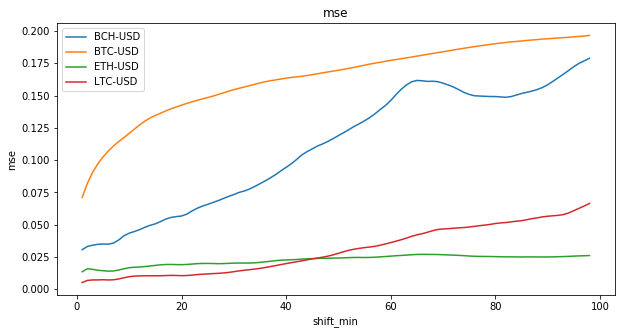

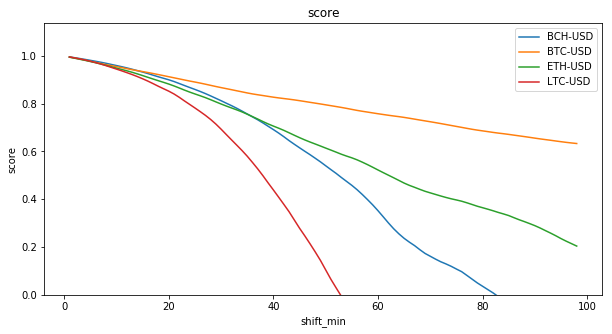

In [116]:
# plot
model_pd_mse = pd.DataFrame(models_mse)
model_pd_score = pd.DataFrame(models_score)

x = [x+1 for x in range(len(model_pd_mse))]
model_pd_mse = model_pd_mse.reindex(x)
model_pd_score = model_pd_score.reindex(x)

ax_mse = model_pd_mse.plot(figsize=(10, 5), title='mse')#, logy=True)
ax_mse.xaxis.label.set_text('shift_min')
ax_mse.yaxis.label.set_text('mse')

ax_score = model_pd_score.plot(figsize=(10, 5), title='score', ylim=0)
ax_score.xaxis.label.set_text('shift_min')
ax_score.yaxis.label.set_text('score')

In [ ]:
# series_avg_copy = series_avg.copy()
# series_avg_copy[keys[3]] = series_avg[keys[3]].shift(-1 * 60 * 0)
# period=60*10
# series_avg_copy[:period].plot(figsize=(14,10), grid=True, subplots=True)
# # series_avg.corr()
# series_avg_copy[:period].corr()

In [92]:
?r2_score